In [104]:
%load_ext autoreload
%autoreload 2

from computage.deage.pls import PLS1
from computage.deage.kdm import KlemeraDoubalEstimator
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, roc_curve, roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from lifelines import CoxPHFitter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# df = df[(df.HSAGEIR > 30) & (df.HSAGEIR < 75)]
# print(df.shape)
# df = df[~df.PERMTH_EXM.isna()]
# print(df.shape)

# df.head()

#tmp
cols = [
    'CRP',
    'CEP',
    'GHP',
    'HAZMNK1R',
    'AMP',
    'TCP',
    'CVP_IGG',
    'APPSI',
    'SPPFEV05',
    'BUP'
]

df = pd.read_csv('data/df.csv', index_col=0)
df = df[~df[cols].isna().any(axis=1)]
df

,SEQN,HSAGEIR,HSSEX,CRP,CEP,GHP,AMP,TCP,BUP,APPSI,...,MOPPCNT,GRPPCNT,PLP,SPPFEV05,PEP6DR,HAZMNK1R,HAZMNK5R,CVP_IGG,MORTSTAT,PERMTH_EXM
1,4,32.000000,2.0,0.21,0.7,4.6,4.1,160.0,11.0,89.0,...,3.40,67.50,441.5,2545.0,80.0,126.0,86.0,2.0,0.0,341.0
2,9,48.583333,2.0,0.21,0.8,5.3,4.0,236.0,14.0,59.0,...,2.90,64.75,235.5,1992.0,76.0,131.0,73.0,1.0,0.0,354.0
3,10,35.666667,1.0,0.21,1.2,4.6,4.5,225.0,14.0,74.0,...,4.30,68.50,180.0,3260.0,72.0,130.0,82.0,2.0,0.0,344.0
4,11,48.500000,1.0,0.33,1.1,9.1,4.1,260.0,14.0,91.0,...,5.20,68.85,443.0,2502.0,84.0,120.0,70.0,1.0,1.0,206.0
5,19,44.250000,1.0,0.21,1.1,5.7,4.2,187.0,10.0,86.0,...,NaN,NaN,75.0,1965.0,76.0,133.0,85.0,1.0,1.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17070,53572,39.250000,2.0,0.30,1.0,5.0,4.0,214.0,9.0,59.0,...,6.60,49.65,237.0,1962.0,68.0,113.0,70.0,1.0,0.0,310.0
17071,53575,66.750000,1.0,0.21,1.1,5.8,3.9,184.0,19.0,64.0,...,6.10,59.30,198.5,1881.0,72.0,157.0,85.0,1.0,1.0,226.0
17072,53581,35.833333,1.0,0.21,1.2,5.3,4.4,196.0,13.0,75.0,...,6.15,51.25,420.0,3195.0,76.0,129.0,90.0,1.0,1.0,114.0
17075,53585,58.166667,1.0,1.60,1.1,7.6,4.1,215.0,15.0,159.0,...,7.15,63.40,178.0,2076.0,76.0,135.0,65.0,1.0,1.0,177.0


In [3]:
df_norm = df.copy()
df_male = df[df.HSSEX == 1].copy()
df_female = df[df.HSSEX == 2].copy()
df_male[cols] = (df_male[cols]-df_male[cols].mean())/df_male[cols].std()
df_female[cols] = (df_female[cols]-df_female[cols].mean())/df_female[cols].std()

In [26]:
# tmp
# pca_ba_mf = []
# n_components = 4 #len(cols)

# fig, axes = plt.subplots(ncols=2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)

# for sex in [1, 2]:
    
#     pca = PCA(n_components=n_components, whiten=True)
#     pca_res = pca.fit_transform(df_norm[df_norm.HSSEX == sex][cols])
#     eigenvalues = pca.explained_variance_

#     CA = df_norm[df_norm.HSSEX == sex].HSAGEIR
#     CA_mean = CA.mean()
#     CA_std =  CA.std()

#     pca_ba = pca_res[:, 0] # First PCA
#     # pca_ba = (pca_ba - pca_ba.mean()) / pca_ba.std()
#     # Convert to BA
#     pca_ba = pca_ba * CA_std + CA_mean
#     a, b = np.polyfit(pca_ba, CA, deg=1)
#     # Add z scores to get True BA (TBA)
#     pca_ba = pca_ba + (CA - CA_mean) / (1 - b) 
#     a, b = np.polyfit(CA, pca_ba, deg=1)

#     score = r2_score(CA, pca_ba)
#     axes[sex-1].scatter(CA, pca_ba, s=0.5, alpha=.2, color={1:'tab:blue', 2:'tab:red'}[sex])
#     pca_ba_mf.append(pca_ba)

#     axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76)*a+b, alpha=.85, linewidth=2, linestyle='--', 
#                      color={1:'tab:blue', 2:'tab:red'}[sex], label='regression CA ~ BA')
#     axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76), alpha=.85, label='curve x=y', color={1:'tab:blue', 2:'tab:red'}[sex])

#     r, pv = stats.pearsonr(df[df.HSSEX == sex].HSAGEIR, pca_ba)
#     axes[sex-1].text(35, 85, f'r={r:.3f}, p<0.00001\n$r^2$={score:.3f}')
#     axes[sex-1].set_ylim(20, 100)
#     axes[sex-1].set_xlim(30, 75)
#     axes[sex-1].set_xlabel('Chronological age')
    
# axes[0].set_ylabel('Biological age')
# axes[0].set_title('Men')
# axes[1].set_title('Women')
# axes[1].legend(loc='lower right')

# plt.suptitle('Principal Component Analysis', y=1.05)

# plt.show()

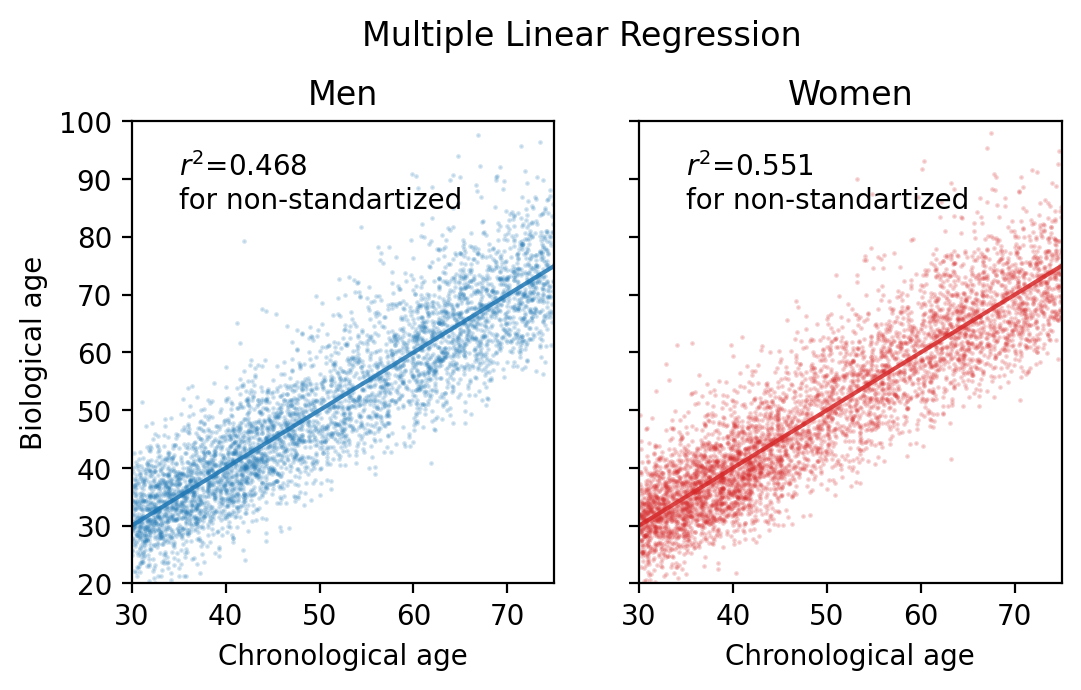

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), dpi=200, sharex=True, sharey=True)

mlr_mf = []

for sex in [1, 2]:

    lr = LinearRegression()
    lr.fit(df_norm[df_norm.HSSEX == sex][cols], df_norm[df_norm.HSSEX == sex].HSAGEIR)
    y_pred = lr.predict(df_norm[df_norm.HSSEX == sex][cols])
    score = r2_score(df_norm[df_norm.HSSEX == sex].HSAGEIR, y_pred)

    # The results from the equations were then standardized so
    # that the mean BA for participants of a given age was equalto CA.
    a, b = np.polyfit(df_norm[df_norm.HSSEX == sex].HSAGEIR, y_pred, deg=1)
    y_pred = y_pred - df_norm[df_norm.HSSEX == sex].HSAGEIR*a
    y_pred = y_pred - y_pred.mean()
    y_pred = y_pred + df_norm[df_norm.HSSEX == sex].HSAGEIR


    axes[sex-1].scatter(df_norm[df_norm.HSSEX == sex].HSAGEIR, y_pred, s=0.5, alpha=.2, color={1:'tab:blue', 2:'tab:red'}[sex])
    mlr_mf.append(y_pred)
    # axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76)*a+b, alpha=.85, linewidth=2, linestyle='--')
    axes[sex-1].plot(np.arange(30, 76), np.arange(30, 76), alpha=.85, color={1:'tab:blue', 2:'tab:red'}[sex], label='curve x=y')
    axes[sex-1].text(35, 85, f'$r^2$={score:.3f}\nfor non-standartized')

    axes[sex-1].set_ylim(20, 100)
    axes[sex-1].set_xlim(30, 75)

    axes[sex-1].set_xlabel('Chronological age')
    
axes[0].set_ylabel('Biological age')
axes[0].set_title('Men')
axes[1].set_title('Women')

plt.suptitle('Multiple Linear Regression', y=1.05)
plt.show()

In [108]:
models = {
    'KDM (unweighted, BA)': KlemeraDoubalEstimator(feature_selection_method='all',
                                  lasso_preselection=False,
                                  weighing=None,
                                  ),
    'KDM (rse, BA)': KlemeraDoubalEstimator(feature_selection_method='all',
                                  lasso_preselection=False,
                                  weighing='rse',
                                  ),
    'KDM (r2, BA)': KlemeraDoubalEstimator(feature_selection_method='all',
                                  lasso_preselection=False,
                                  weighing='r2',
                                  ),
    'KDM (r2/rse, BA)': KlemeraDoubalEstimator(feature_selection_method='all',
                                  lasso_preselection=False,
                                  weighing='r2|rse',
                                  ),                                  
    'MLR': LinearRegression(),
    'PLS-1': PLS1(n_components=1),
    'PLS-2': PLS1(n_components=2),
    'PLS-10': PLS1(n_components=10),
    'RF': RandomForestRegressor(200),
    'kNN-5': KNeighborsRegressor(5),
    'kNN-10': KNeighborsRegressor(10),
    'kNN-15': KNeighborsRegressor(15)
}

#Males
BA_male = pd.DataFrame()
X = df_male[cols]
CA = df_male.HSAGEIR
# CA = (CA - CA.mean()) / CA.std(ddof=1)
for model_name, model in models.items():
        model.fit(X, CA)
        y_pred = model.predict(X)
        BA_male[model_name] = y_pred

#Females
BA_female = pd.DataFrame()
X = df_female[cols]
CA = df_female.HSAGEIR
for model_name, model in models.items():
        model.fit(X, CA)
        y_pred = model.predict(X)
        BA_female[model_name] = y_pred

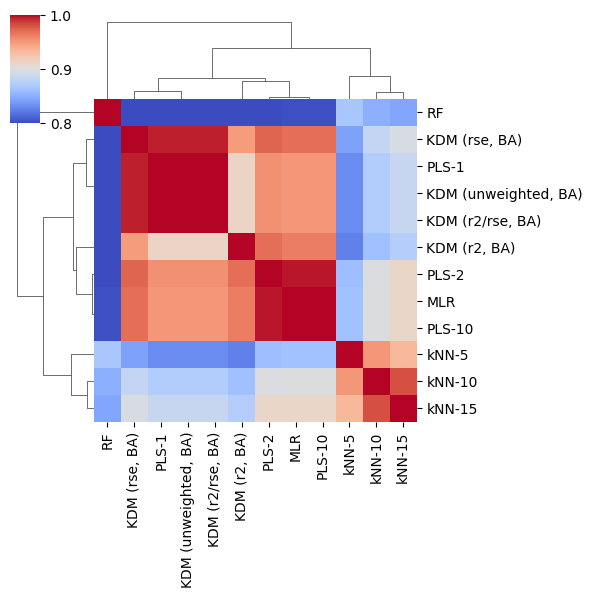

In [109]:
BA_male_ = BA_male.copy()
BA_male_['CA'] = df_male.HSAGEIR

sns.clustermap(BA_male.corr(), figsize=(6,6), vmin=0.8, cmap='coolwarm')

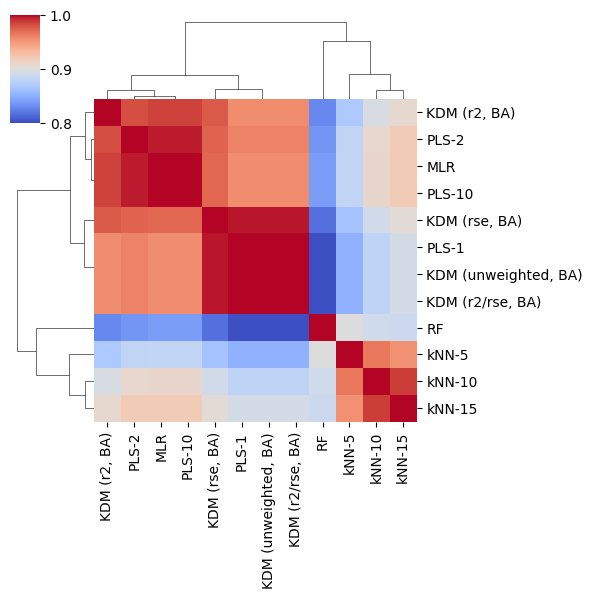

In [110]:
sns.clustermap(BA_female.corr(), figsize=(6,6), vmin=0.8, cmap='coolwarm')

/tmp/ipykernel_49312/3152960298.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right');


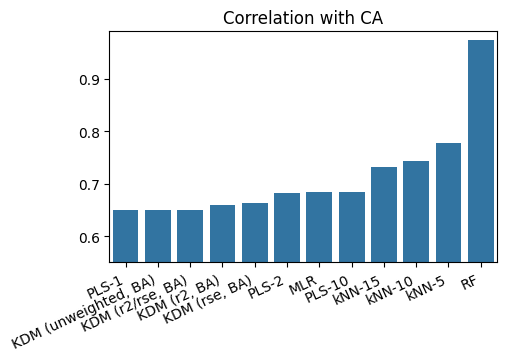

In [111]:
plt.figure(figsize=(5,3))
ax = sns.barplot(BA_male.corrwith(df_male.HSAGEIR).sort_values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right');
ax.set_title('Correlation with CA')
ax.set_ylim([0.55, 0.99])
plt.show()

/tmp/ipykernel_49312/3755305741.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([rocs], columns=['rocauc male', 'rocauc female'], index=[name])])


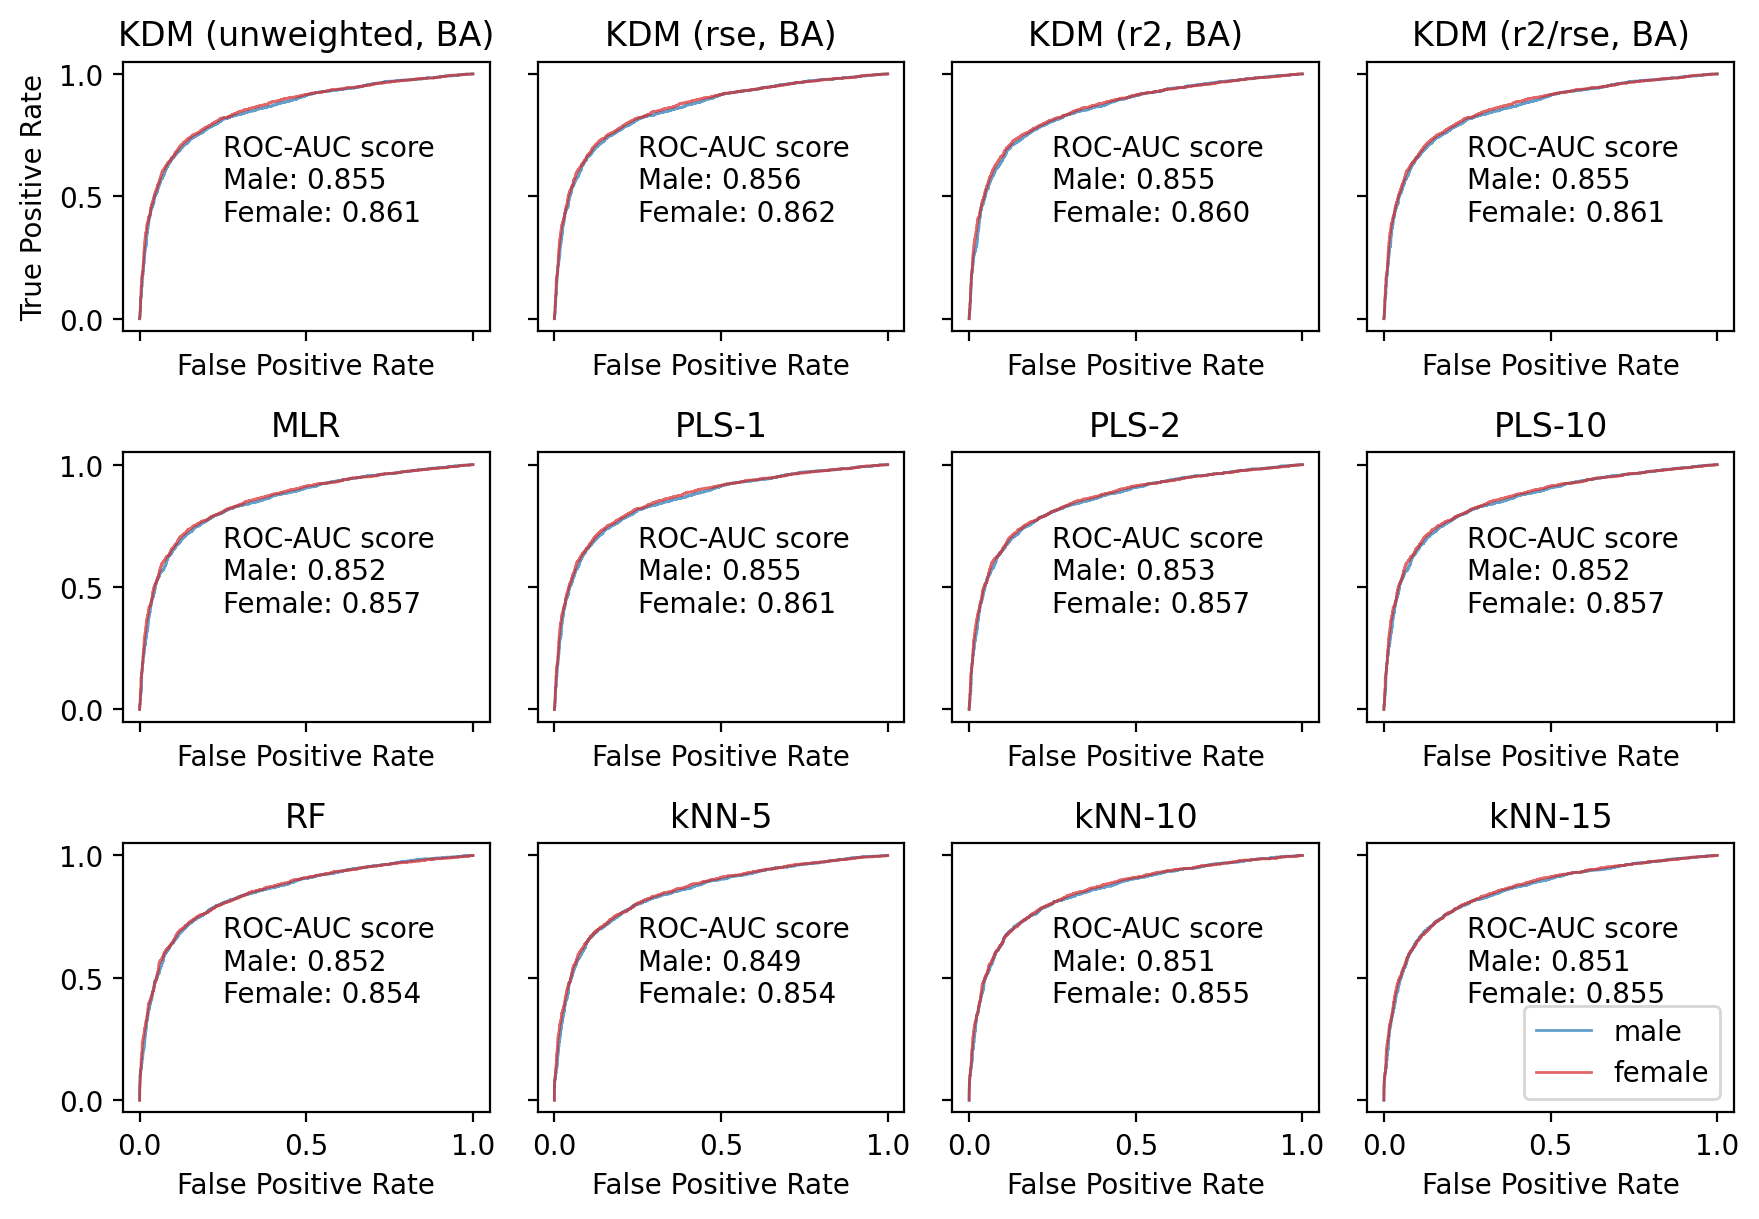

In [132]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(9.0, 6.2), dpi=200, sharex=True, sharey=True)
colors = {'male':'tab:blue', 'female':'tab:red'}

male_summaries = []
female_summaries = []
results = pd.DataFrame(columns=['rocauc male', 'rocauc female'])
for ax, name in zip(axes.flatten(), models.keys()):
    rocs = []
    for sex, sex_df, BA_df in zip(['male', 'female'], 
                                    [df_male, df_female], 
                                    [BA_male, BA_female]):
        CA = sex_df.HSAGEIR
        Delta = BA_df[name] - CA #age acceleration
        Cox_train = pd.DataFrame({
            'MORTSTAT':sex_df.MORTSTAT,
            'PERMTH_EXM':sex_df.PERMTH_EXM,
            'Delta':Delta,
            'CA':CA
            })
        cph = CoxPHFitter()
        cph.fit(Cox_train, duration_col="PERMTH_EXM", event_col="MORTSTAT")

        res = cph.predict_cumulative_hazard(Cox_train) # predict_survival_function(Cox_train)
        res = np.array(res).T
        res = res[:, -1]

        fpr, tpr, _ = roc_curve(sex_df.MORTSTAT, res)

        ax.plot(fpr, tpr, color=colors[sex], 
                            alpha=0.7, linewidth=1, label=f'{sex}')
        ax.set_title(name)        
        ax.set_xlabel('False Positive Rate')
        
        rocauc = roc_auc_score(sex_df.MORTSTAT, res)
        rocs.append(rocauc)
        if sex == 'male':
            male_summaries.append(cph.summary)
        else:
            female_summaries.append(cph.summary)

    results = pd.concat([results, pd.DataFrame([rocs], columns=['rocauc male', 'rocauc female'], index=[name])])
        
    ax.text(0.25, 0.4, f'ROC-AUC score\nMale: {rocs[0]:.3f}\nFemale: {rocs[1]:.3f}')

axes.flatten()[-1].legend()    
axes.flatten()[0].set_ylabel('True Positive Rate')
plt.tight_layout()
plt.show()

In [131]:
results.sort_values('rocauc male', ascending=False)


,rocauc male,rocauc female
"KDM (rse, BA)",0.855940,0.861507
"KDM (unweighted, BA)",0.855337,0.861377
"KDM (r2/rse, BA)",0.855337,0.861377
PLS-1,0.855337,0.861377
"KDM (r2, BA)",0.854792,0.859915
PLS-2,0.852999,0.856769
MLR,0.852098,0.857178
PLS-10,0.852098,0.857178
RF,0.851936,0.854075
kNN-15,0.851414,0.854977


In [126]:

columns = ['CA HR (95% CI)', 'CA SE', 'Delta HR (95% CI)', 'Delta SE']

# all p-vals are very low, I'm adding '***' without a doubt
values = [
    [f"{i.round(2).loc['CA', 'exp(coef)']} ({i.round(2).loc['CA', 'exp(coef) lower 95%']}-{i.round(2).loc['CA', 'exp(coef) upper 95%']})***" for i in male_summaries],
    [f"{i.round(3).loc['CA', 'se(coef)']}" for i in male_summaries],
    [f"{i.round(2).loc['Delta', 'exp(coef)']} ({i.round(2).loc['Delta', 'exp(coef) lower 95%']}-{i.round(2).loc['Delta', 'exp(coef) upper 95%']})***" for i in male_summaries],
    [f"{i.round(3).loc['Delta', 'se(coef)']}" for i in male_summaries],

]

male_cox_results = pd.DataFrame(values, index=columns, columns=models.keys()).T
male_cox_results

,CA HR (95% CI),CA SE,Delta HR (95% CI),Delta SE
"KDM (unweighted, BA)",1.09 (1.09-1.1)***,0.002,1.02 (1.02-1.02)***,0.001
"KDM (rse, BA)",1.09 (1.09-1.1)***,0.002,1.02 (1.02-1.03)***,0.001
"KDM (r2, BA)",1.09 (1.09-1.1)***,0.002,1.02 (1.02-1.03)***,0.001
"KDM (r2/rse, BA)",1.09 (1.09-1.1)***,0.002,1.02 (1.02-1.02)***,0.001
MLR,1.12 (1.12-1.13)***,0.003,1.05 (1.04-1.06)***,0.003
PLS-1,1.12 (1.12-1.13)***,0.003,1.05 (1.04-1.05)***,0.002
PLS-2,1.12 (1.12-1.13)***,0.003,1.05 (1.04-1.06)***,0.003
PLS-10,1.12 (1.12-1.13)***,0.003,1.05 (1.04-1.06)***,0.003
RF,1.11 (1.11-1.12)***,0.003,1.12 (1.1-1.13)***,0.008
kNN-5,1.11 (1.1-1.11)***,0.002,1.04 (1.03-1.04)***,0.003


In [128]:
columns = ['CA HR (95% CI)', 'CA SE', 'Delta HR (95% CI)', 'Delta SE']

# all p-vals are very low, I'm adding '***' without a doubt
values = [
    [f"{i.round(2).loc['CA', 'exp(coef)']} ({i.round(2).loc['CA', 'exp(coef) lower 95%']}-{i.round(2).loc['CA', 'exp(coef) upper 95%']})" for i in female_summaries],
    [f"{i.round(3).loc['CA', 'se(coef)']}" for i in female_summaries],
    [f"{i.round(2).loc['Delta', 'exp(coef)']} ({i.round(2).loc['Delta', 'exp(coef) lower 95%']}-{i.round(2).loc['Delta', 'exp(coef) upper 95%']})" for i in female_summaries],
    [f"{i.round(3).loc['Delta', 'se(coef)']}" for i in female_summaries],

]

female_cox_results = pd.DataFrame(values, index=columns, columns=models.keys()).T
female_cox_results

,CA HR (95% CI),CA SE,Delta HR (95% CI),Delta SE
"KDM (unweighted, BA)",1.1 (1.09-1.1),0.002,1.03 (1.03-1.03),0.002
"KDM (rse, BA)",1.1 (1.09-1.1),0.002,1.03 (1.03-1.03),0.002
"KDM (r2, BA)",1.1 (1.09-1.1),0.002,1.03 (1.03-1.03),0.002
"KDM (r2/rse, BA)",1.1 (1.09-1.1),0.002,1.03 (1.03-1.03),0.002
MLR,1.12 (1.12-1.13),0.003,1.05 (1.04-1.06),0.003
PLS-1,1.13 (1.13-1.14),0.003,1.06 (1.05-1.07),0.003
PLS-2,1.12 (1.12-1.13),0.003,1.05 (1.04-1.05),0.003
PLS-10,1.12 (1.12-1.13),0.003,1.05 (1.04-1.06),0.003
RF,1.11 (1.11-1.12),0.003,1.11 (1.09-1.13),0.009
kNN-5,1.11 (1.1-1.12),0.003,1.04 (1.03-1.05),0.004
